In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import itertools

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

def get_pool_type(x):
    if isinstance(x, str) and x.endswith("Embedding-Sum"): return "Embedding:Sum"
    elif isinstance(x, str) and x.endswith("Embedding-Max"): return "Embedding:Max"
    elif isinstance(x, str) and x.endswith("Embedding-Mean"): return "Embedding:Mean"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Sum"): return "GAT:Sum"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Max"): return "GAT:Max"
    elif isinstance(x, str) and x.startswith("GAT") and x.endswith("Mean"): return "GAT:Mean"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Sum"): return "GIN:Sum"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Max"): return "GIN:Max"
    elif isinstance(x, str) and x.startswith("GIN") and x.endswith("Mean"): return "GIN:Mean"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Sum"): return "GCN:Sum"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Max"): return "GCN:Max"
    elif isinstance(x, str) and x.startswith("GCN") and x.endswith("Mean"): return "GCN:Mean"
    elif  isinstance(x, str) and x.endswith("Sum"): return "Sum"
    elif isinstance(x, str) and x.endswith("Max"): return "Max"
    elif isinstance(x, str) and x.endswith("Mean"): return "Mean"
    elif isinstance(x, str) and x.endswith("Set2Set"): return "Set2Set"
    else: return pd.NA

api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished":
        dist_data.append(run.summary._json_dict | run.config | {'config' : str(run._attrs['config'])} |
                    {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(dist_data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df['pool_type'] = runs_df['model'].apply(get_pool_type)
runs_df.to_csv("project.csv")

In [3]:
print(f'Total computation time: {round(runs_df["_runtime"].sum() / (60 * 60), 2)} hours')

Total computation time: 1649.75 hours


In [4]:
def get_acc_and_std(dataset, group_col, acc_col='test_accuracy', std_col='test_accuracy_std', latex=False, reg=False):
    data = []

    for (grouping_name, grouping_df) in dataset.groupby(group_col):

        if reg:
            best_idx = grouping_df[acc_col].idxmin()

            if math.isnan(best_idx):
                continue

            loss = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]

            log_loss = grouping_df.loc[best_idx, 'test_error_log']
            log_std = grouping_df.loc[best_idx, 'test_error_log_std']

            if latex:
                result = f'{loss:.3f} {{\scriptsize $\pm {std:.3f}$}} {log_loss:.3f} {{\scriptsize $\pm {log_std:.3f}$}} & '
            else:
                result = f"{loss:.3f} \u00B1 {std:.3f}"

        else:
            best_idx = grouping_df[acc_col].idxmax()
        
            if math.isnan(best_idx):
                continue
        
            acc = grouping_df.loc[best_idx, acc_col]
            std = grouping_df.loc[best_idx, std_col]
            if latex:
                result = f'{acc:.1f} \scriptsize $\pm {std:.1f}$'
            else:
                result = f"{acc:.3f} \u00B1 {std:.3f}"

        data.append({group_col[i] : grouping_name[i] for i in range(len(group_col))} |
                    {acc_col : result, 'run_id' : grouping_df.loc[best_idx, 'run_id']})
    
    return pd.DataFrame(data)

In [5]:
runs_df.pivot_table(index=['model_type', 'pool_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                        \
dataset                         Alchemy Alchemy10K ENZYMES IMDB-BINARY  MUTAG   
model_type pool_type                                                            
1-WL+NN    Embedding:Max            3.0       95.0   190.0       282.0  195.0   
           Embedding:Mean           6.0       77.0   145.0       271.0  188.0   
           Embedding:Sum            5.0      273.0   137.0       293.0  202.0   
           Max                      NaN        NaN    86.0        70.0  150.0   
           Mean                     NaN        NaN    76.0        67.0  120.0   
           Sum                      NaN        NaN    85.0        67.0  130.0   
GNN        GAT:Max                  NaN        NaN    17.0        17.0   36.0   
           GAT:Mean                 NaN        NaN    28.0        15.0   28.0   
           GAT:Sum                  NaN        NaN    26.0        17.0   37.0   
           GCN:Max                  NaN        NaN    31.0        22.0   37.0   
           GCN:Mean                 NaN        NaN    19.0        26.0   26.0   
           GCN:Sum                  NaN        NaN    30.0        29.0   27.0   
           GIN:Max                  NaN        NaN    21.0        17.0   28.0   
           GIN:Mean                 NaN        NaN    31.0         9.0   31.0   
           GIN:Sum                  NaN        NaN    26.0         9.0   38.0   

                                                                      
dataset                    NCI1 PROTEINS REDDIT-BINARY Zinc Zinc 10k  
model_type pool_type                                                  
1-WL+NN    Embedding:Max   44.0    245.0          33.0  3.0     33.0  
           Embedding:Mean  70.0    216.0          37.0  4.0     24.0  
           Embedding:Sum   53.0    215.0          29.0  3.0     18.0  
           Max             26.0     35.0          40.0  NaN      NaN  
           Mean            19.0     27.0          40.0  NaN      NaN  
           Sum             14.0     29.0          41.0  NaN      NaN  
GNN        GAT:Max         11.0     10.0           6.0  NaN      NaN  
           GAT:Mean        12.0     10.0           6.0  NaN      NaN  
           GAT:Sum         15.0     16.0           6.0  NaN      NaN  
           GCN:Max         17.0     10.0           9.0  NaN      NaN  
           GCN:Mean        19.0     16.0           5.0  NaN      NaN  
           GCN:Sum         17.0     14.0           9.0  NaN      NaN  
           GIN:Max         25.0     20.0           3.0  NaN      NaN  
           GIN:Mean        18.0     26.0           9.0  NaN      NaN  
           GIN:Sum         20.0     11.0           9.0  NaN      NaN

In [8]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   40.5 \scriptsize $\pm 7.4$   
           Embedding:Mean  42.6 \scriptsize $\pm 9.0$   
           Embedding:Sum   48.3 \scriptsize $\pm 8.1$   
           Max             16.7 \scriptsize $\pm 4.2$   
           Mean            18.2 \scriptsize $\pm 4.8$   
           Sum             18.0 \scriptsize $\pm 6.2$   
GNN        GAT:Max         31.2 \scriptsize $\pm 6.0$   
           GAT:Mean        28.9 \scriptsize $\pm 5.9$   
           GAT:Sum         34.4 \scriptsize $\pm 7.0$   
           GCN:Max         33.1 \scriptsize $\pm 7.5$   
           GCN:Mean        29.9 \scriptsize $\pm 5.7$   
           GCN:Sum         31.7 \scriptsize $\pm 7.2$   
           GIN:Max         29.2 \scriptsize $\pm 6.2$   
           GIN:Mean        31.7 \scriptsize $\pm 6.7$   
           GIN:Sum         28.9 \scriptsize $\pm 8.7$   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.4 \scriptsize $\pm 4.9$   
           Embedding:Mean  72.4 \scriptsize $\pm 4.1$   
           Embedding:Sum   72.0 \scriptsize $\pm 3.8$   
           Max             52.0 \scriptsize $\pm 5.3$   
           Mean            59.4 \scriptsize $\pm 5.8$   
           Sum             57.5 \scriptsize $\pm 5.1$   
GNN        GAT:Max         70.7 \scriptsize $\pm 4.8$   
           GAT:Mean        70.9 \scriptsize $\pm 3.7$   
           GAT:Sum         72.2 \scriptsize $\pm 4.5$   
           GCN:Max         73.5 \scriptsize $\pm 4.1$   
           GCN:Mean        74.7 \scriptsize $\pm 3.8$   
           GCN:Sum         73.0 \scriptsize $\pm 4.4$   
           GIN:Max         70.8 \scriptsize $\pm 4.7$   
           GIN:Mean        71.1 \scriptsize $\pm 5.4$   
           GIN:Sum         69.5 \scriptsize $\pm 4.8$   

                                                        \
dataset                                          MUTAG   
model_type pool_type                                     
1-WL+NN    Embedding:Max   81.1 \scriptsize $\pm 11.2$   
           Embedding:Mean   84.1 \scriptsize $\pm 9.1$   
           Embedding:Sum    85.1 \scriptsize $\pm 8.6$   
           Max             73.8 \scriptsize $\pm 12.4$   
           Mean            77.1 \scriptsize $\pm 11.5$   
           Sum             66.8 \scriptsize $\pm 13.9$   
GNN        GAT:Max         71.1 \scriptsize $\pm 12.2$   
           GAT:Mean         74.8 \scriptsize $\pm 9.1$   
           GAT:Sum         82.1 \scriptsize $\pm 11.2$   
           GCN:Max         74.5 \scriptsize $\pm 11.3$   
           GCN:Mean        75.0 \scriptsize $\pm 10.4$   
           GCN:Sum         81.5 \scriptsize $\pm 10.3$   
           GIN:Max         77.3 \scriptsize $\pm 10.7$   
           GIN:Mean         82.4 \scriptsize $\pm 9.8$   
           GIN:Sum          84.6 \scriptsize $\pm 8.7$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   82.7 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.1 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 2.2$   
           Max             58.6 \scriptsize $\pm 3.3$   
           Mean            64.0 \scriptsize $\pm 3.3$   
           Sum             56.9 \scriptsize $\pm 3.8$   
GNN        GAT:Max         58.0 \scriptsize $\pm 4.2$   
           GAT:Mean        66.1 \scriptsize $\pm 2.8$   
           GAT:Sum         69.8 \scriptsize $\pm 2.6$   
           GCN:Max         61.1 \scriptsize $\pm 3.6$   
           GCN:Mean        68.9 \scriptsize $\pm 2.4$   
           GCN:Sum         70.4 \scriptsize $\pm 2.1$   
           GIN:Max         79.9 \scriptsize $\pm 2.2$   
           GIN:Mean        71

In [7]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=False)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                                                  \
dataset            ENZYMES     IMDB-BINARY           MUTAG            NCI1   
model_type                                                                   
1-WL+NN     48.267 ± 8.109  72.400 ± 4.056  85.117 ± 8.614  83.601 ± 2.180   
GNN         34.400 ± 6.997  74.680 ± 3.841  84.573 ± 8.711  79.859 ± 2.224   

                                            
dataset           PROTEINS   REDDIT-BINARY  
model_type                                  
1-WL+NN     75.197 ± 3.917  78.450 ± 2.728  
GNN         74.281 ± 5.073  86.920 ± 3.187

In [80]:
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'dataset'], acc_col='test_accuracy', std_col='test_accuracy_std', latex=True)
latex_table = latex_table.pivot_table(index=['model_type'], 
                                      columns='dataset', values=['test_accuracy'], aggfunc=lambda x: x)
latex_table

test_accuracy                              \
dataset                        ENZYMES                 IMDB-BINARY   
model_type                                                           
1-WL+NN     48.3 \scriptsize $\pm 8.1$  72.4 \scriptsize $\pm 4.1$   
GNN         34.4 \scriptsize $\pm 7.0$  74.7 \scriptsize $\pm 3.8$   

                                                                    \
dataset                          MUTAG                        NCI1   
model_type                                                           
1-WL+NN     85.1 \scriptsize $\pm 8.6$  83.6 \scriptsize $\pm 2.2$   
GNN         84.6 \scriptsize $\pm 8.7$  79.9 \scriptsize $\pm 2.2$   

                                                                    
dataset                       PROTEINS               REDDIT-BINARY  
model_type                                                          
1-WL+NN     75.2 \scriptsize $\pm 3.9$  78.4 \scriptsize $\pm 2.7$  
GNN         74.3 \scriptsize $\pm 5.1$  86.9 \scriptsize $\pm 3.2$

In [64]:
pd.set_option('display.max_colwidth', None)
latex_table = get_acc_and_std(runs_df, group_col=['model_type', 'pool_type', 'dataset'], acc_col='test_error', std_col='test_error_std',
                               latex=True, reg=True)
latex_table = latex_table.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['test_error'], aggfunc=lambda x: x)
latex_table

test_error  \
dataset                                                                                Alchemy   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.648 {\scriptsize $\pm 0.003$} -0.511 {\scriptsize $\pm 0.009$} &    
           Embedding:Mean  0.617 {\scriptsize $\pm 0.003$} -0.564 {\scriptsize $\pm 0.005$} &    
           Embedding:Sum   0.600 {\scriptsize $\pm 0.004$} -0.625 {\scriptsize $\pm 0.032$} &    

                                                                                                \
dataset                                                                             Alchemy10K   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.409 {\scriptsize $\pm 0.003$} -1.023 {\scriptsize $\pm 0.009$} &    
           Embedding:Mean  0.355 {\scriptsize $\pm 0.004$} -1.269 {\scriptsize $\pm 0.020$} &    
           Embedding:Sum   0.305 {\scriptsize $\pm 0.001$} -1.740 {\scriptsize $\pm 0.042$} &    

                                                                                                \
dataset                                                                                   Zinc   
model_type pool_type                                                                             
1-WL+NN    Embedding:Max   0.382 {\scriptsize $\pm 0.005$} -0.963 {\scriptsize $\pm 0.014$} &    
           Embedding:Mean  0.348 {\scriptsize $\pm 0.010$} -1.056 {\scriptsize $\pm 0.028$} &    
           Embedding:Sum   0.384 {\scriptsize $\pm 0.004$} -0.958 {\scriptsize $\pm 0.010$} &    

                                                                                                
dataset                                                                               Zinc 10k  
model_type pool_type                                                                            
1-WL+NN    Embedding:Max   0.659 {\scriptsize $\pm 0.007$} -0.417 {\scriptsize $\pm 0.011$} &   
           Embedding:Mean  0.484 {\scriptsize $\pm 0.009$} -0.726 {\scriptsize $\pm 0.019$} &   
           Embedding:Sum   0.465 {\scriptsize $\pm 0.009$} -0.765 {\scriptsize $\pm 0.020$} &

In [9]:
runs_df.pivot_table(index=['model_type'], 
                                columns='dataset', values=['test_accuracy'], aggfunc=lambda x: len(x))

test_accuracy                                               \
dataset          Alchemy Alchemy10K ENZYMES IMDB-BINARY  MUTAG   NCI1   
model_type                                                              
1-WL+NN             14.0      445.0   719.0      1050.0  985.0  226.0   
GNN                  NaN        NaN   229.0       161.0  288.0  154.0   

                                                  
dataset    PROTEINS REDDIT-BINARY  Zinc Zinc 10k  
model_type                                        
1-WL+NN       767.0         220.0  10.0     75.0  
GNN           133.0          62.0   NaN      NaN

In [66]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='test_accuracy', std_col='test_accuracy_std')
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['run_id'], aggfunc=lambda x: x)
latex_svm

run_id                                          
dataset                     ENZYMES IMDB-BINARY     MUTAG      NCI1  PROTEINS
model_type pool_type                                                         
1-WL+NN    Embedding:Max   60562q4o    rrb09qm5       NaN  kr2efr0t  xwp3x7vc
           Embedding:Mean  ztju6f9s    hsoebyq6       NaN  rvfi5ksh  0wseenmc
           Embedding:Sum   o84jwl99         NaN  vvw0t1se  9c64l23v  yt6edt4n
GNN        GAT:Sum         r0hzi69w         NaN       NaN       NaN       NaN
           GCN:Max         hhc3yspq    423spwqo       NaN       NaN       NaN
           GCN:Mean             NaN    h41v1r4j       NaN       NaN       NaN
           GCN:Sum              NaN    onhuomtj       NaN       NaN  4bkmzbdv
           GIN:Max              NaN         NaN       NaN  ircwl3vt  nor2tequ
           GIN:Mean        6lezhkeo         NaN       NaN  zu2bqs8z  q0nhlr39
           GIN:Sum              NaN         NaN  5z6vl3b3  l7jvcxkk       NaN

In [67]:
latex_svm = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_lin_accuracies', std_col='svm_lin_accuracies_std', latex=True)
latex_svm = latex_svm.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_lin_accuracies'], aggfunc=lambda x: x)
latex_svm

svm_lin_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   36.9 \scriptsize $\pm 5.6$   
           Embedding:Mean  37.4 \scriptsize $\pm 6.6$   
           Embedding:Sum   34.4 \scriptsize $\pm 5.5$   
GNN        GAT:Sum         33.2 \scriptsize $\pm 5.9$   
           GCN:Max         37.3 \scriptsize $\pm 6.9$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.0 \scriptsize $\pm 6.2$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   68.9 \scriptsize $\pm 4.8$   
           Embedding:Mean  71.2 \scriptsize $\pm 3.9$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.5 \scriptsize $\pm 4.3$   
           GCN:Mean        74.4 \scriptsize $\pm 4.1$   
           GCN:Sum         74.3 \scriptsize $\pm 4.4$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                        \
dataset                                          MUTAG   
model_type pool_type                                     
1-WL+NN    Embedding:Max                           NaN   
           Embedding:Mean                          NaN   
           Embedding:Sum    86.4 \scriptsize $\pm 8.9$   
GNN        GAT:Sum                                 NaN   
           GCN:Max                                 NaN   
           GCN:Mean                                NaN   
           GCN:Sum                                 NaN   
           GIN:Max                                 NaN   
           GIN:Mean                                NaN   
           GIN:Sum         58.4 \scriptsize $\pm 35.0$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   82.9 \scriptsize $\pm 1.9$   
           Embedding:Mean  82.7 \scriptsize $\pm 1.8$   
           Embedding:Sum   83.4 \scriptsize $\pm 2.1$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         67.4 \scriptsize $\pm 2.2$   
           GIN:Mean        69.2 \scriptsize $\pm 2.2$   
           GIN:Sum         70.1 \scriptsize $\pm 3.1$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   73.9 \scriptsize $\pm 4.1$  
           Embedding:Mean  66.9 \scriptsize $\pm 4.2$  
           Embedding:Sum   74.5 \scriptsize $\pm 4.0$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.8 \scriptsize $\pm 4.2$  
           GIN:Max         74.7 \scriptsize $\pm 4.2$  
           GIN:Mean        67.7 \scriptsize $\pm 4.4$  
           GIN:Sum                                NaN

In [68]:
latex_rbf = get_acc_and_std(runs_df[runs_df['Tags'] == 'replicate_run'], group_col=['model_type', 'pool_type', 'dataset'],
                             acc_col='svm_rbf_accuracies', std_col='svm_rbf_accuracies_std', latex=True)
latex_rbf = latex_rbf.pivot_table(index=['model_type', 'pool_type'], 
                                      columns='dataset', values=['svm_rbf_accuracies'], aggfunc=lambda x: x)
latex_rbf

svm_rbf_accuracies  \
dataset                                       ENZYMES   
model_type pool_type                                    
1-WL+NN    Embedding:Max   41.2 \scriptsize $\pm 5.8$   
           Embedding:Mean  43.4 \scriptsize $\pm 7.0$   
           Embedding:Sum   45.0 \scriptsize $\pm 7.0$   
GNN        GAT:Sum         35.9 \scriptsize $\pm 6.0$   
           GCN:Max         28.5 \scriptsize $\pm 5.7$   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean        29.4 \scriptsize $\pm 5.9$   
           GIN:Sum                                NaN   

                                                       \
dataset                                   IMDB-BINARY   
model_type pool_type                                    
1-WL+NN    Embedding:Max   69.2 \scriptsize $\pm 5.0$   
           Embedding:Mean  72.8 \scriptsize $\pm 4.3$   
           Embedding:Sum                          NaN   
GNN        GAT:Sum                                NaN   
           GCN:Max         73.0 \scriptsize $\pm 4.2$   
           GCN:Mean        74.6 \scriptsize $\pm 4.6$   
           GCN:Sum         73.6 \scriptsize $\pm 4.1$   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum                                NaN   

                                                       \
dataset                                         MUTAG   
model_type pool_type                                    
1-WL+NN    Embedding:Max                          NaN   
           Embedding:Mean                         NaN   
           Embedding:Sum   83.2 \scriptsize $\pm 7.5$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max                                NaN   
           GIN:Mean                               NaN   
           GIN:Sum         86.0 \scriptsize $\pm 7.4$   

                                                       \
dataset                                          NCI1   
model_type pool_type                                    
1-WL+NN    Embedding:Max   83.1 \scriptsize $\pm 2.0$   
           Embedding:Mean  83.4 \scriptsize $\pm 1.9$   
           Embedding:Sum   83.6 \scriptsize $\pm 1.9$   
GNN        GAT:Sum                                NaN   
           GCN:Max                                NaN   
           GCN:Mean                               NaN   
           GCN:Sum                                NaN   
           GIN:Max         73.0 \scriptsize $\pm 1.9$   
           GIN:Mean        70.2 \scriptsize $\pm 2.0$   
           GIN:Sum         70.9 \scriptsize $\pm 2.3$   

                                                       
dataset                                      PROTEINS  
model_type pool_type                                   
1-WL+NN    Embedding:Max   75.2 \scriptsize $\pm 4.0$  
           Embedding:Mean  73.7 \scriptsize $\pm 4.6$  
           Embedding:Sum   74.5 \scriptsize $\pm 3.8$  
GNN        GAT:Sum                                NaN  
           GCN:Max                                NaN  
           GCN:Mean                               NaN  
           GCN:Sum         73.3 \scriptsize $\pm 4.6$  
           GIN:Max         74.6 \scriptsize $\pm 4.6$  
           GIN:Mean        71.5 \scriptsize $\pm 4.2$  
           GIN:Sum                                NaN

# Distance Matrix

In [554]:
from torch_geometric.utils import degree
from utils import NormalizedDegree
import torch_geometric.transforms as T

dataset_name = 'ENZYMES'

model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')

dataset = model_gnn.dataset
train_index, test_index = model_gnn.train_index, model_gnn.test_index
agg_data = model_gnn.data_aggregate

In [555]:
model_wlnn.config['k_wl'] = 1

In [556]:
from utils import Wrapper_WL_TUDataset, Constant_Long

if dataset._data.x is None:
    print('No node features found. Using constant function for 1WL+NN.')
    dataset.transform = Constant_Long(0)

wl_dataset = Wrapper_WL_TUDataset(dataset, k_wl=model_wlnn.config['k_wl'], wl_convergence=False)

In [557]:
wl_dataset.x.unique(sorted=False)[0]

tensor(230)

In [558]:
if dataset._data.x is None:
    print('No node features found. Using one-hot degree for GNNs.')
    max_degree = 0
    degs = []
    for data in dataset:
        degs += [degree(data.edge_index[0], dtype=torch.long)]
        max_degree = max(max_degree, degs[-1].max().item())

    if max_degree < 1000:
        dataset.transform = T.OneHotDegree(max_degree)
    else:
        deg = torch.cat(degs, dim=0).to(torch.float)
        mean, std = deg.mean().item(), deg.std().item()
        dataset.transform = NormalizedDegree(mean, std)

In [559]:
# Sample 10 random graphs from the test set
indices_graphs = torch.randperm(len(test_index))[:10]
indices_graphs = test_index[indices_graphs]
single_index = test_index[0]

global_error_mean = 0.0
global_error_std = 0.0

X  = None
Y = None

df_dist_matrix = pd.DataFrame()
df_tsne = pd.DataFrame()

with torch.no_grad():
    for idx in test_index:
        num_nodes = dataset[idx].num_nodes
        x_gnn = model_gnn.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        # Calculate distance matrix
        distance_matrix_gnn = torch.cdist(x_gnn, x_gnn, p=2)
        distance_matrix_gnn = distance_matrix_gnn / distance_matrix_gnn.max() if distance_matrix_gnn.max() > 0 else distance_matrix_gnn
        distance_matrix_wl = torch.sign((x_wl.unsqueeze(1) - x_wl)**2)

        dist_data = pd.DataFrame(list(itertools.product(['GNN Node Representations', '1-WL Colors'], range(0, num_nodes), range(0, num_nodes))), columns=['type', 'i', 'j'])
        dist_data['distance'] = torch.cat([distance_matrix_gnn.flatten(), distance_matrix_wl.flatten()], dim=0).numpy()
        dist_data['idx'] = idx.item()

        error_matrix = (distance_matrix_gnn - distance_matrix_wl).abs()
        dist_data['normed_error'] = f"Graph Index: {idx}\nMAE: {round(error_matrix.mean().item(), 2)} ± {round(error_matrix.std().item(), 2)}"
        global_error_mean += error_matrix.mean().item()
        global_error_std += error_matrix.std().item()

        if X is None and Y is None:
            X = x_gnn
            Y = x_wl
        else:
            X  = torch.cat([X, x_gnn])
            Y = torch.cat([Y, x_wl])

        df_dist_matrix = pd.concat([df_dist_matrix, dist_data], axis=0, ignore_index=True)

print(f'Global normed error: {round(global_error_mean / len(test_index), 2)} ± {round(global_error_std / len(test_index), 2)}')

Global normed error: 0.49 ± 0.3


In [560]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

data = []
for eps in eps_values:

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)            

            if removed_indices != []:
                removed_indices = sample_indices[torch.tensor(removed_indices)]
                sample_indices = torch.tensor([idx for idx in sample_indices if idx not in removed_indices])
            
        Y_pred[sample_indices] = class_label

    f1 = f1_score(Y, Y_pred, average='macro')

    data.append({'epsilon': eps, 'f1_score' : round(f1 * 100, 2)})

data = pd.DataFrame(data)
data


,epsilon,f1_score
0,0.100,70.45
1,0.050,62.33
2,0.010,54.63
3,0.001,52.55


In [602]:
from sklearn.metrics import f1_score

eps_values = [0.10, 0.05, 0.01, 0.001]

data = []
for eps in eps_values:

    Y_pred = torch.ones_like(Y) * (Y.max() + 1)

    for class_label in Y.unique(sorted=False):

        # Distance matrix between nodes
        sample_indices = torch.argwhere(Y == class_label).squeeze(0)
        X_query = X[sample_indices].reshape(-1, X.shape[1])

        if len(sample_indices) > 1:

            # Calculate pairwise distance matrix
            distance = torch.cdist(X_query, X_query, p=2)

            removed_indices = []
            while True:
                num_points_outside_eps_ball = (distance > eps).count_nonzero(dim=1)

                # If all remaining points are contained in one eps-ball, we terminate
                if (num_points_outside_eps_ball == 0.0).all():
                    break
                
                # Remove the index that is the furthes away from all other points
                index = num_points_outside_eps_ball.argmax()
                distance[index, :] = 0.0
                distance[:, index] = 0.0

                removed_indices.append(index)

            for idx in range(X.shape[0]):
                if idx in sample_indices and idx not in removed_indices:
                    data.append([idx, class_label])
                elif idx not in sample_indices and \
                    ((torch.cdist(X_query, X[idx].unsqueeze(0), p=2) < eps).count_nonzero(dim=1) == 0).all():
                        
                    data.append([idx, class_label])
         

hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey
hey


In [595]:
def calculate_max_accuracy(dataset):
        # Get unique samples in x
        unique_samples, unique_indices = torch.unique(dataset[:, :-1], dim=0, return_inverse=True)

        max_correct = 0
        total_samples = 0

        for i in range(unique_samples.shape[0]):
            # Find indices of matching samples in the dataset. 
            # Necessary to use flatten() to get a 1D tensor such that 'dataset[matching_indices]' returns a 2D tensor.
            matching_indices = torch.nonzero(unique_indices == i, as_tuple=False).flatten()

            # Get matching samples and labels
            matching_samples = dataset[matching_indices]
            matching_labels = matching_samples[:, -1]

            # Count the occurrences of each class label
            _, label_counts = torch.unique(matching_labels, return_counts=True)

            # Update the maximum correct count
            max_correct += torch.max(label_counts)

            # Update the total number of samples
            total_samples += matching_samples.shape[0]

        # Calculate the maximal accuracy
        max_accuracy = max_correct / total_samples
        return max_accuracy

In [603]:
data = torch.tensor(data)
calculate_max_accuracy(data)

tensor(0.0102)

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


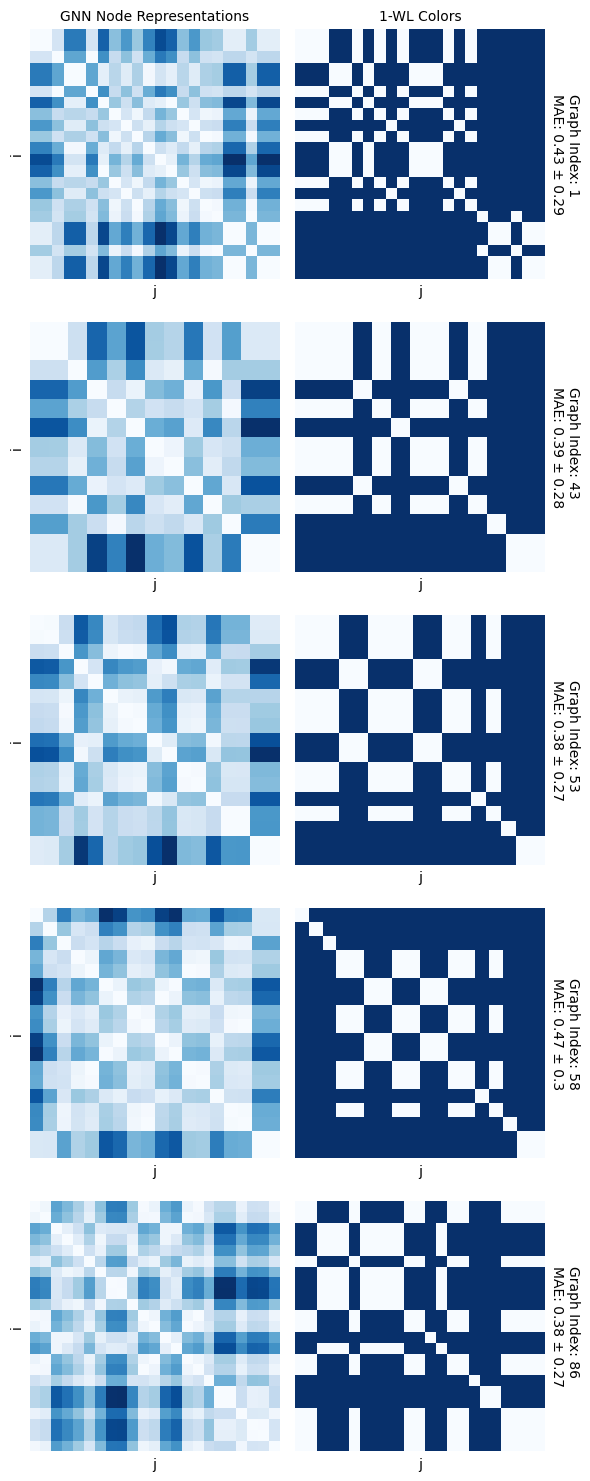

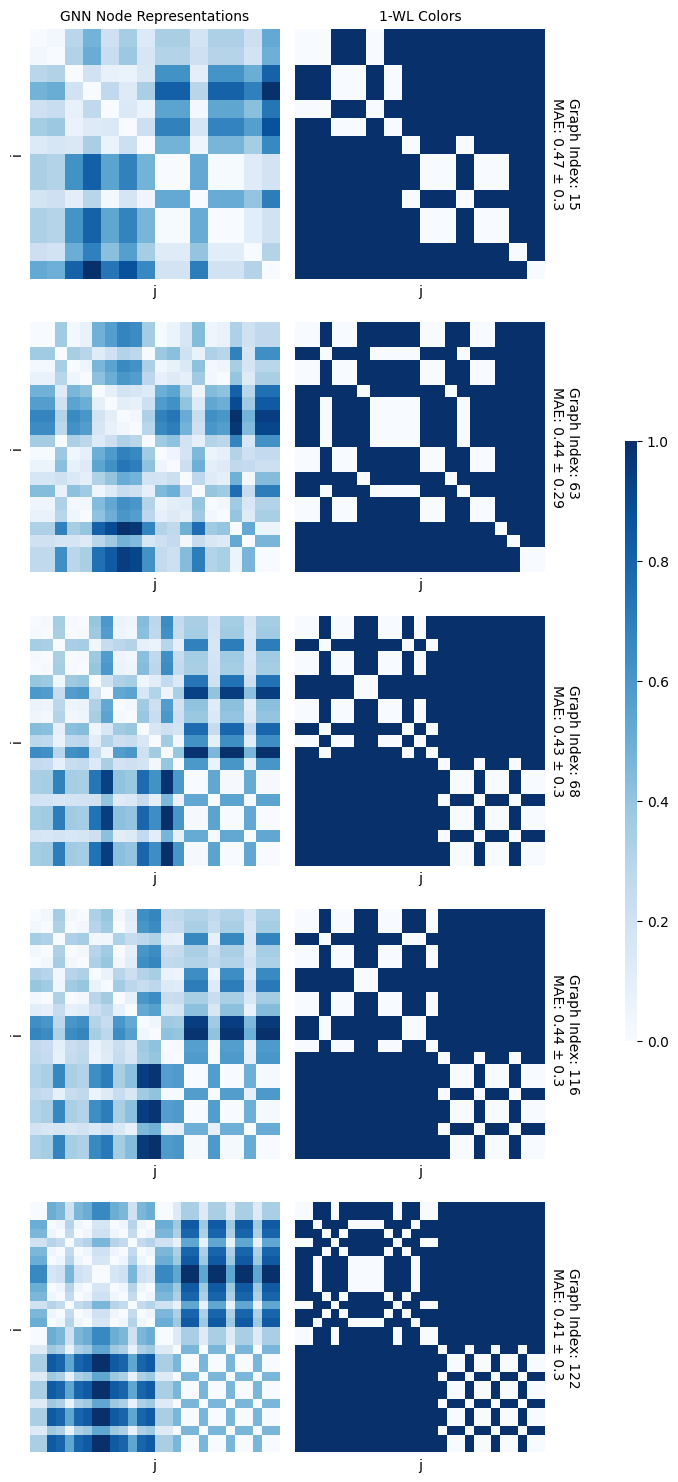

In [206]:
def facet_heatmap(data, color, **kwargs):
    data = data.pivot(index="i", columns='j', values='distance')
    sns.heatmap(data, cmap='Blues', **kwargs)

index_split = [indices_graphs[:5], indices_graphs[5:]]
for i in range(2):
    data = df_dist_matrix[df_dist_matrix['idx'].isin(index_split[i])]
    g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)

    if i == 0:
        g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
    else:
        cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes
        g.map_dataframe(facet_heatmap, cbar_ax=cbar_ax, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)

    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    
    #g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_{i}.pdf'.format(i), bbox_inches='tight')

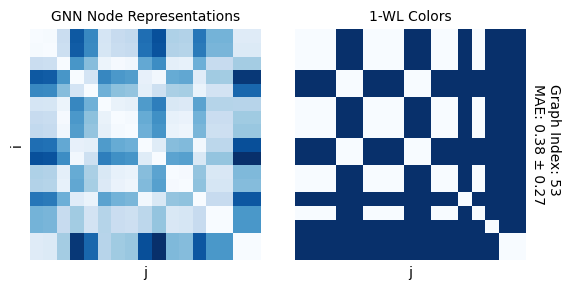

In [199]:
data = df_dist_matrix[df_dist_matrix['idx'] == test_index[torch.randint(0, len(test_index), (1,)).item()]]
g = sns.FacetGrid(data, col='type', row='normed_error', sharex='row', sharey='row', margin_titles=True)
g.map_dataframe(facet_heatmap, cbar=False, vmin=0, vmax=1, square=True, xticklabels=False, yticklabels=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
#g.savefig(f'../Latex/Figures/heatmaps_{dataset.name}_single.pdf', bbox_inches='tight')

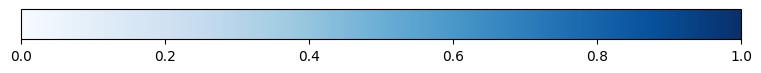

In [378]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 0.5))
img = pl.imshow(a, cmap="Blues")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
#pl.savefig("../Latex/Figures/colorbar.pdf", bbox_inches='tight')

# Clustering Metric

In [1]:
from sklearn import metrics

all_metrics = ['rand_score', 'adjusted_rand_score', 'normalized_mutual_info_score', 'adjusted_mutual_info_score',
               'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']
def evaluate(y_pred, y_true):
    rs = metrics.rand_score(y_true, y_pred)
    ars = metrics.adjusted_rand_score(y_true, y_pred)
    nmi = metrics.normalized_mutual_info_score(y_true, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_true, y_pred)
    hom = metrics.homogeneity_score(y_true, y_pred)
    com = metrics.completeness_score(y_true, y_pred)
    vms = metrics.v_measure_score(y_true, y_pred)
    fws = metrics.fowlkes_mallows_score(y_true, y_pred)


    return {'rand_score': rs, 'adjusted_rand_score': ars, 'normalized_mutual_info_score': nmi,
            'adjusted_mutual_info_score': ami, 'homogeneity_score': hom, 'completeness_score': com,
            'v_measure_score': vms, 'fowlkes_mallows_score': fws}

In [14]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_wl = wl_dataset[idx].x

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

In [14]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS, Birch, BisectingKMeans
dist_data = []
num_cluster = len(torch.unique(y_test))

kmeans = KMeans(n_clusters=num_cluster, random_state=42, init='k-means++', n_init='auto').fit(x_test)
dist_data.append(evaluate(kmeans.labels_, y_test) | {'name': 'kmeans', 'num_cluster': num_cluster})

aggC_ward = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward').fit(x_test)
dist_data.append(evaluate(aggC_ward.labels_, y_test) | {'name': 'aggC_ward', 'num_cluster': num_cluster})

aggC_avg = AgglomerativeClustering(n_clusters=num_cluster, linkage='average').fit(x_test)
dist_data.append(evaluate(aggC_avg.labels_, y_test) | {'name': 'aggC_avg', 'num_cluster': num_cluster})

dbscan = DBSCAN(eps=0.5, min_samples=5).fit(x_test)
dist_data.append(evaluate(dbscan.labels_, y_test) | {'name': 'dbscan', 'num_cluster': num_cluster})

optics = OPTICS(min_samples=5).fit(x_test)
dist_data.append(evaluate(optics.labels_, y_test) | {'name': 'optics', 'num_cluster': num_cluster})

birch = Birch(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(birch.labels_, y_test) | {'name': 'birch', 'num_cluster': num_cluster})

bisectingKmeans = BisectingKMeans(n_clusters=num_cluster).fit(x_test)
dist_data.append(evaluate(bisectingKmeans.labels_, y_test) | {'name': 'bisectingKmeans', 'num_cluster': num_cluster})

df_cluster_metrics = pd.DataFrame(dist_data)

In [19]:
df_cluster_metrics

,rand_score,adjusted_rand_score,normalized_mutual_info_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score,name,num_cluster
0,0.966394,0.297932,0.687398,0.613401,0.780458,0.614167,0.687398,0.367233,kmeans,149
1,0.966792,0.292508,0.710801,0.640931,0.812982,0.631438,0.710801,0.369268,aggC_ward,149
2,0.948761,0.340135,0.653657,0.592979,0.655570,0.651755,0.653657,0.367724,aggC_avg,149
3,0.209294,0.014530,0.146240,0.130254,0.080907,0.759746,0.146240,0.208999,dbscan,149
4,0.635521,-0.000065,0.423289,0.258958,0.374406,0.486854,0.423289,0.114880,optics,149
5,0.955879,0.296869,0.617139,0.546602,0.641659,0.594424,0.617139,0.322979,birch,149
6,0.964425,0.242018,0.651642,0.568485,0.743872,0.579759,0.651642,0.308943,bisectingKmeans,149


In [37]:
with torch.no_grad():
    x_train = []
    y_train = []

    for idx in train_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_train.append(x_gnn)
        y_train.append(x_wl)

    x_train = torch.cat(x_train, dim=0)
    y_train = torch.cat(y_train, dim=0)

    x_test = []
    y_test = []

    for idx in test_index:
        x_gnn = model.gnn(dataset[idx].x, dataset[idx].edge_index)
        x_gnn = model.pool(x_gnn, dataset[idx].batch)
        x_wl = dataset[idx].y

        x_test.append(x_gnn)
        y_test.append(x_wl)

    x_test = torch.cat(x_test, dim=0)
    y_test = torch.cat(y_test, dim=0)

# KNN

In [21]:
knn_runs = ['o84jwl99', 'r0hzi69w', 'hsoebyq6', 'h41v1r4j', '9c64l23v', 'ircwl3vt', 'xwp3x7vc', 'nor2tequ', 'vvw0t1se', 'tku7invn']

df_knn = pd.DataFrame()
api = wandb.Api()
runs = api.runs("eric-bill/BachelorThesisExperiments")

for run in runs:
    if run.state == "finished" and run.id in knn_runs:

        knn = run.history(keys=['k', 'knn_accuracies', 'knn_accuracies_std'])
        knn['dataset'] = run.config['dataset']
        knn['model_type'] = get_model_type(run.config['model'])
        knn['test_accuracy'] = run.summary['test_accuracy']
        knn['run_id'] = run.id

        df_knn = pd.concat([df_knn, knn], ignore_index=True)

df_knn

,_step,k,knn_accuracies,knn_accuracies_std,dataset,model_type,test_accuracy,run_id
0,0,1,85.742690,7.896076,MUTAG,GNN,83.350876,tku7invn
1,1,2,81.923977,9.387200,MUTAG,GNN,83.350876,tku7invn
2,2,3,83.988304,8.453578,MUTAG,GNN,83.350876,tku7invn
3,3,4,84.508772,7.569330,MUTAG,GNN,83.350876,tku7invn
4,4,5,85.035088,7.356859,MUTAG,GNN,83.350876,tku7invn
...,...,...,...,...,...,...,...,...
1895,195,196,25.800000,5.283783,ENZYMES,1-WL+NN,47.866665,o84jwl99
1896,196,197,25.466667,5.281637,ENZYMES,1-WL+NN,47.866665,o84jwl99
1897,197,198,25.633333,5.280027,ENZYMES,1-WL+NN,47.866665,o84jwl99
1898,198,199,25.366667,5.576615,ENZYMES,1-WL+NN,47.866665,o84jwl99


In [44]:
pivot_knn = get_acc_and_std(df_knn, group_col=['model_type','dataset'], acc_col='knn_accuracies', std_col='k', latex=False)
pivot_knn.pivot_table(index=['model_type'], columns=['dataset'], values=['knn_accuracies'], aggfunc=lambda x: x)

knn_accuracies                                                    
dataset           ENZYMES   IMDB-BINARY        MUTAG        NCI1     PROTEINS
model_type                                                                   
1-WL+NN        56.3 ± 1.0   72.3 ± 11.0  86.7 ± 10.0  83.9 ± 5.0  73.9 ± 19.0
GNN            51.6 ± 1.0  74.3 ± 132.0  88.3 ± 38.0  77.5 ± 2.0  74.9 ± 27.0

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/538782078.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])


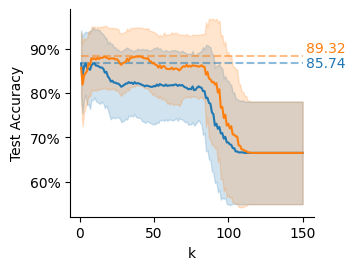

In [211]:
def plot_knn(data, x, y, std, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    sns.lineplot(data_max, x=x, y='max', color=kwargs['color'], alpha=0.5, linestyle='--')

    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    # Fix if the text is to close togehter
    if y_max < 88.3:
        y_max -= 1
    else:
        y_max += 1
    
    line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}", color=kwargs['color'])
    line.fill_between(data[x], data[y] - data[std], data[y] + data[std], alpha=0.2, color=kwargs['color'])

    # y_max = data['test_accuracy'].max()
    # data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    # sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='-')
    # line.axes.text(data[x].max() + 2, y_max, f"{round(y_max, 2)}")

for dataset_name in ['MUTAG']:#df_knn.dataset.unique():

    g = sns.FacetGrid(df_knn[df_knn['dataset'] == dataset_name], col='dataset', hue='model_type', col_wrap=3, hue_order=['1-WL+NN', 'GNN'], margin_titles=True, sharex=False, sharey=False)
    g.map_dataframe(plot_knn, x='k', y='knn_accuracies', std='knn_accuracies_std', legend=None)
    #g.add_legend(frameon=True)
    g.set_titles(col_template="", row_template="")
    g.set_axis_labels("k", "Test Accuracy")
    g.axes[0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0].get_yticks()])

    #sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

    #g.savefig(f'../LaTeX/Figures/knn_{dataset_name}.pdf', bbox_inches='tight')
    plt.show()

# SVM Viz

In [178]:
dataset_name = 'MUTAG'

wlnn_name = "1-WL+NN: 86.4% Accuracy"
gnn_name = "GNN: 51.9% Accuracy"
model = torch.load(f'saved_models/GNN_{dataset_name}.pt')

In [179]:
def calc_svm_boundary_contour(X, Y, n_points=5, **kwargs):
    clf = SVC(kernel='linear', **kwargs)
    clf.fit(X, Y)

    # Create a grid of points
    x_min = np.min(X.T, axis=1)
    x_max = np.max(X.T, axis=1)
    h = (x_max - x_min) / n_points

    arr_arange = [np.arange(x_min[i], x_max[i], h[i]) for i in range(len(x_min))]
    xx = np.meshgrid(*arr_arange)
    xx = np.hstack([dim.reshape(-1, 1) for dim in np.meshgrid(*arr_arange)])

    # Calculate the decision values for the grid points
    Z = clf.predict(xx)
        
    return pd.DataFrame({'x': xx[:, 0], 'y': xx[:, 1], 'class': Z})

In [180]:
model_gnn = torch.load(f'saved_models/GNN_{dataset_name}.pt')
X_gnn = model_gnn.data_aggregate[:, :-1]
Y_gnn = model_gnn.data_aggregate[:, -1]

X_gnn = TSNE(n_components=2).fit_transform(X_gnn)

df_gnn = pd.DataFrame(X_gnn, columns=['x', 'y'])
df_gnn['class'] = Y_gnn
df_gnn['model_type'] = gnn_name
df_gnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_gnn, Y_gnn, n_points=100)
df_svm['model_type'] = gnn_name
df_svm['scatter'] = 0

df_gnn = pd.concat([df_gnn, df_svm])

model_wlnn = torch.load(f'saved_models/WLNN_{dataset_name}.pt')
X_wlnn = model_wlnn.data_aggregate[:, :-1]
Y_wlnn = model_wlnn.data_aggregate[:, -1]

X_wlnn = TSNE(n_components=2).fit_transform(X_wlnn)

df_wlnn = pd.DataFrame(X_wlnn, columns=['x', 'y'])
df_wlnn['class'] = Y_wlnn
df_wlnn['model_type'] = wlnn_name
df_wlnn['scatter'] = 1

df_svm = calc_svm_boundary_contour(X_wlnn, Y_wlnn, n_points=100)
df_svm['model_type'] = wlnn_name
df_svm['scatter'] = 0

df_wlnn = pd.concat([df_wlnn, df_svm])

df_svm = pd.concat([df_gnn, df_wlnn])

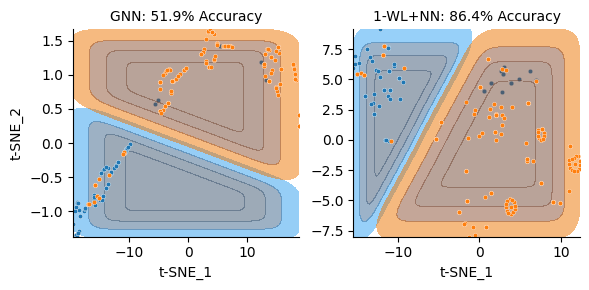

In [181]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

g = sns.FacetGrid(df_svm, col='model_type', hue='class', margin_titles=True, sharex=False, sharey=False)
g.map_dataframe(custom_plotter, x='x', y='y')

g.set_titles(col_template="{col_name}", row_template="{row_name}")
#g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f't-SNE_1', f't-SNE_2')

x_min_gnn, y_min_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].min()
x_max_gnn, y_max_gnn = df_svm[df_svm['model_type'] == gnn_name][['x', 'y']].max()

g.axes[0, 0].set_xlim(x_min_gnn, x_max_gnn)
g.axes[0, 0].set_ylim(y_min_gnn, y_max_gnn)

x_min_wlnn, y_min_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].min()
x_max_wlnn, y_max_wlnn = df_svm[df_svm['model_type'] == wlnn_name][['x', 'y']].max()
g.axes[0, 1].set_xlim(x_min_wlnn, x_max_wlnn)
g.axes[0, 1].set_ylim(y_min_wlnn, y_max_wlnn)

#g.savefig(f'../LaTeX/figures/tsne_svm_lin_{dataset_name}.pdf', bbox_inches='tight')

# Quantil

In [45]:
x = [[1, 2], [5, 2], [10, 8], [50, 3]]
data = pd.DataFrame(x, columns=['q', 'res'])

In [123]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'Quantile' : f'{int(q*100)}%', 'train_accuracy' : dataframe.loc[i]['train_accuracy'],
                             'val_accuracy' : dataframe.loc[i]['val_accuracy'], 'test_accuracy' : dataframe.loc[i]['test_accuracy'],
                            } | grouping_info)

    return pd.DataFrame(rows)

In [124]:
df_qunatil = calc_quantil_performance(runs_df, ['dataset', 'model_type'], quantils=[0.01, 0.05, 0.10, 0.25, 0.5, 1.0])
df_qunatil['difference'] = df_qunatil['train_accuracy'] - df_qunatil['test_accuracy']

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


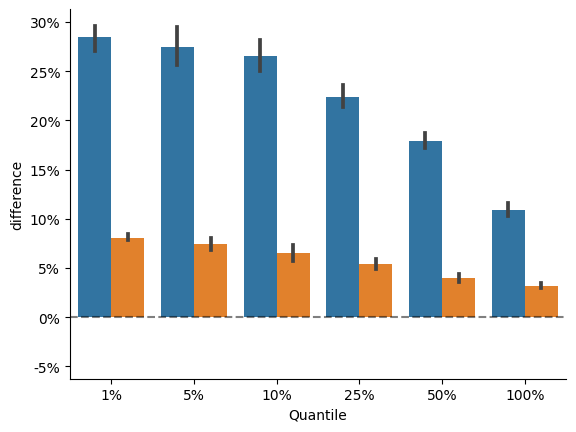

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


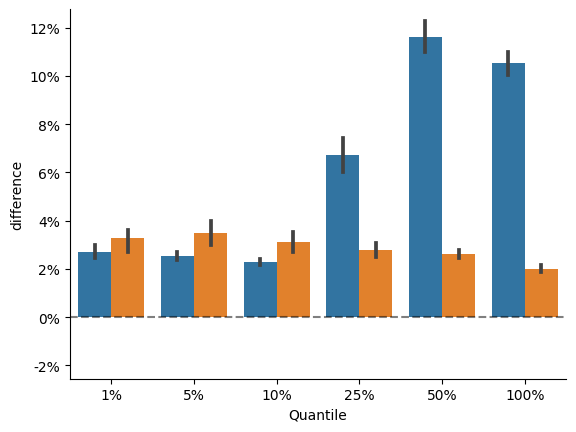

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


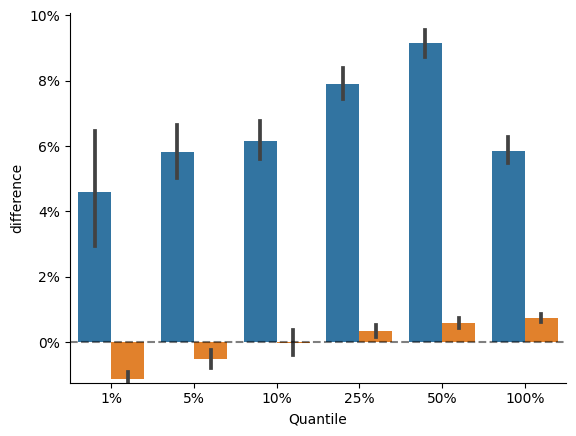

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


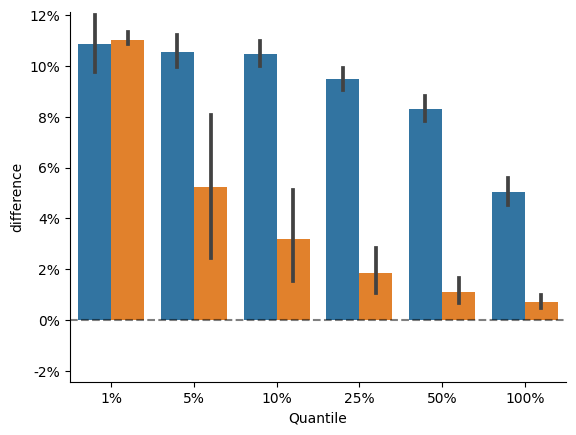

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


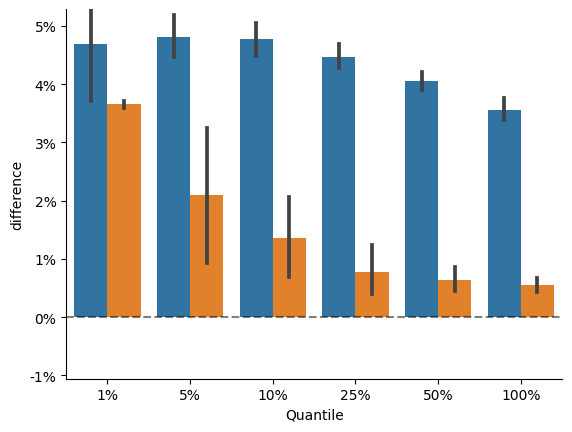

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/3835903218.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])


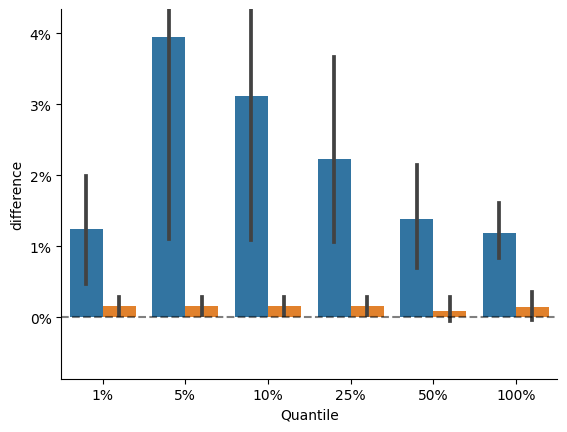

In [152]:
for dataset_name in df_qunatil['dataset'].unique():
    df = df_qunatil[df_qunatil['dataset'] == dataset_name]

    ax = sns.barplot(df, x='Quantile', y='difference', hue='model_type', hue_order=['1-WL+NN', 'GNN'], estimator='mean')
    sns.despine(bottom = False, left = False)

    #bar.set_title('Absolute Difference in Classification Accuracies between Training and Testing')


    y_max = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().max().abs().item()
    y_min = df[['difference', 'Quantile', 'model_type']].groupby(['Quantile', 'model_type']).mean().min().item()

    if y_min > 0:
        y_min = - 0.2 * y_max

    ax.set_ylim([1.1* y_min, 1.1 * y_max])

    ax.set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in ax.get_yticks()])

    ax.axhline(0.0, color='black', linestyle='--', alpha=0.5, snap=True)
    ax.legend_.remove()

    fig = ax.get_figure()
    #fig.savefig(f'../LaTeX/figures/train_test_diff_{dataset_name}.pdf', bbox_inches='tight')

    plt.show()

In [159]:
import pylab

fig = pylab.figure()

figlegend = pylab.figure(figsize=(3,2))
figlegend.legend(ax.get_legend_handles_labels()[0], ax.get_legend_handles_labels()[1], ncol=2)
figlegend.show()
figlegend.savefig(f'../LaTeX/figures/train_test_diff_legend.pdf', bbox_inches='tight')


/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_1709/211676164.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figlegend.show()


<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

# Unbalanceness

In [8]:
dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name="PROTEINS").shuffle()
dataset.y.unique(sorted=False, return_counts=True)

(tensor([1, 0]), tensor([450, 663]))

In [4]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1", "MUTAG", "REDDIT-BINARY", "REDDIT-MULTI-5K"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

dataset,ENZYMES,IMDB-BINARY,IMDB-MULTI,MUTAG,NCI1,PROTEINS,REDDIT-BINARY,REDDIT-MULTI-5K
shannon_diversity,1.0,1.0,1.0,0.92,1.0,0.973,1.0,1.0


In [55]:
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

dist_data = []
for run in runs:
    if run.state == "finished" and ': Theoretical Accuracy' in run.name:
        history = run.history()
        history.sort_values(by='k_wl', ascending=True, inplace=True)

        row = f'& {run.config["dataset"]} '
        last_acc = 0.0
        for acc in history['max_acc']:
            if acc > last_acc:
                row += f'& {acc:.2f} '
            else:
                row += f'& - '
            last_acc = acc
        row += '\\\\'
        print(row)

& FRANKENSTEIN & 0.63 & 0.77 & 0.88 & 0.89 & 0.89 & - \\
& Peking_1 & 1.00 & - & - & - & - & - \\
& KKI & 1.00 & - & - & - & - & - \\
& AIDS & 1.00 & 1.00 & - & - & - & - \\
& OHSU & 1.00 & - & - & - & - & - \\
& DHFR & 0.92 & 0.95 & 1.00 & 1.00 & - & - \\
& BZR & 0.96 & 0.99 & 1.00 & - & - & - \\
& COX2 & 0.93 & 0.96 & 0.99 & 1.00 & - & - \\
& NCI109 & 0.92 & 1.00 & 1.00 & 1.00 & - & - \\
& REDDIT-BINARY & 0.84 & 1.00 & - & - & - & - \\
& PTC_MR & 0.92 & 0.98 & 0.99 & - & - & - \\
& DD & 1.00 & - & - & - & - & - \\
& COLLAB & 0.61 & 0.98 & - & - & - & - \\
& MUTAG & 0.93 & 0.96 & 0.99 & 1.00 & - & - \\
& NCI1 & 0.91 & 1.00 & 1.00 & 1.00 & - & - \\
& IMDB-MULTI & 0.44 & 0.63 & - & - & - & - \\
& IMDB-BINARY & 0.61 & 0.89 & - & - & - & - \\
& PROTEINS & 0.92 & 1.00 & - & - & - & - \\
& ENZYMES & 0.81 & 1.00 & - & - & - & - \\


# Number of 1-WL Iterations Dependency

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/2086039469.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{int(y) if y.

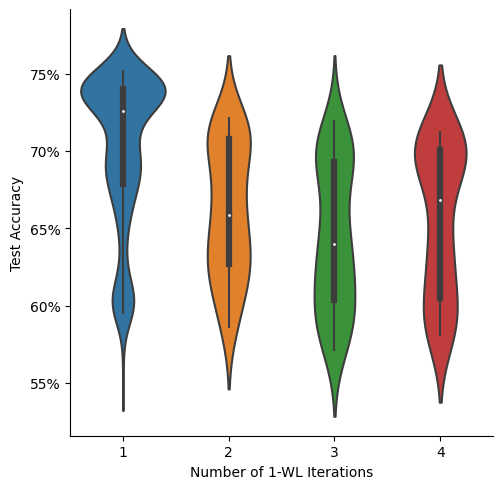

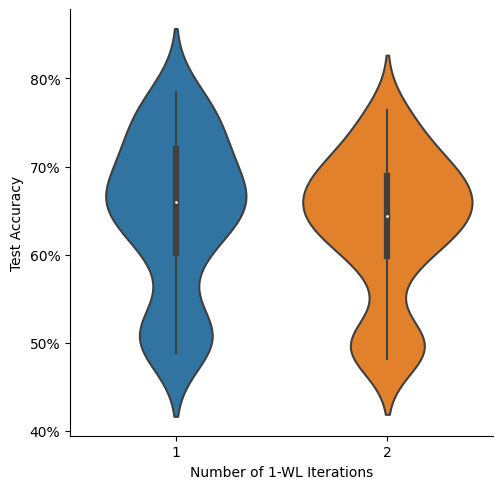

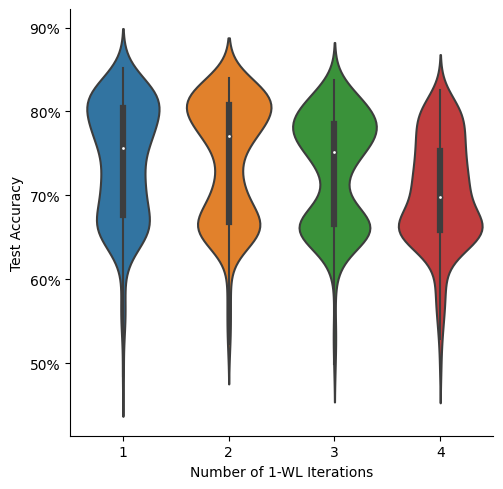

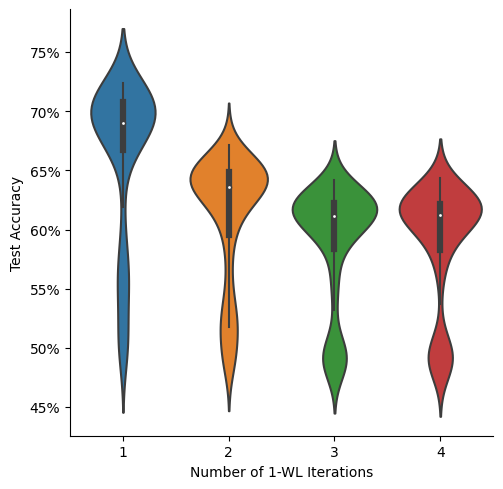

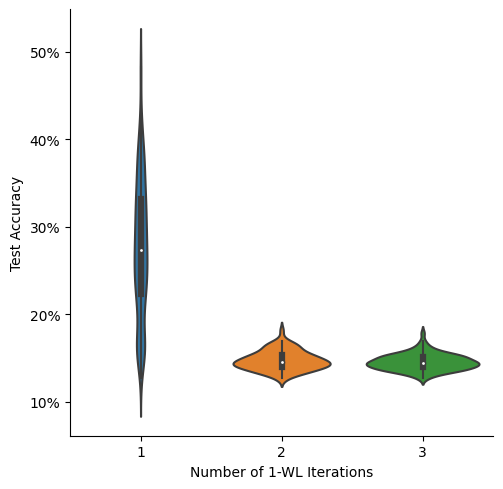

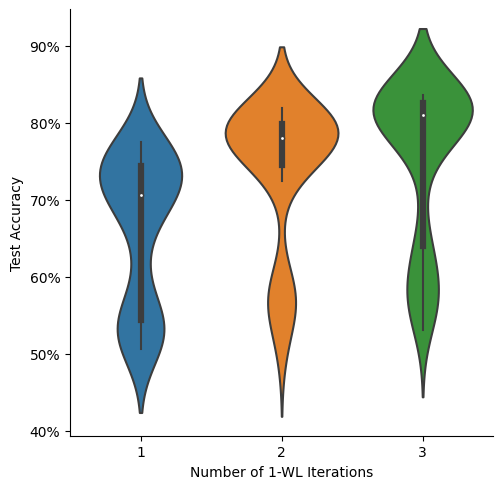

In [15]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_accuracy']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

for ds in k_wl_df['dataset'].unique():
    g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_accuracy', x='k_wl', kind='violin')
    g.set_titles('{col_name}')
    g.set_ylabels('Test Accuracy')
    g.set_xlabels('Number of 1-WL Iterations')
    g.axes[0, 0].set_yticklabels([f'{int(y) if y.is_integer() else y}%' for y in g.axes[0, 0].get_yticks()])

    #g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])
/var/folders/gk/0jn5z2112g5b638tcpy_xs980000gn/T/ipykernel_16227/3831054847.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])


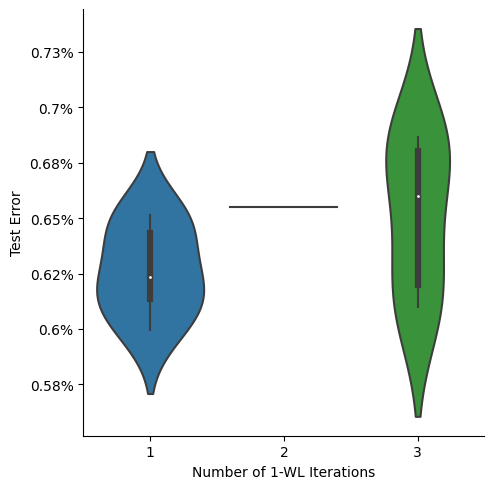

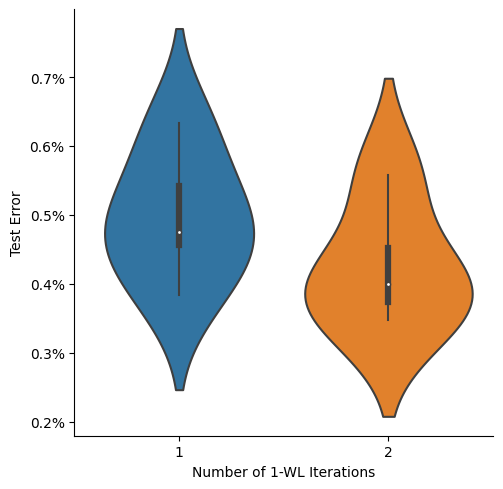

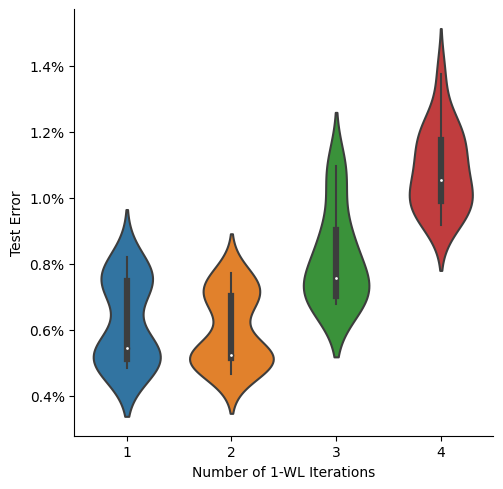

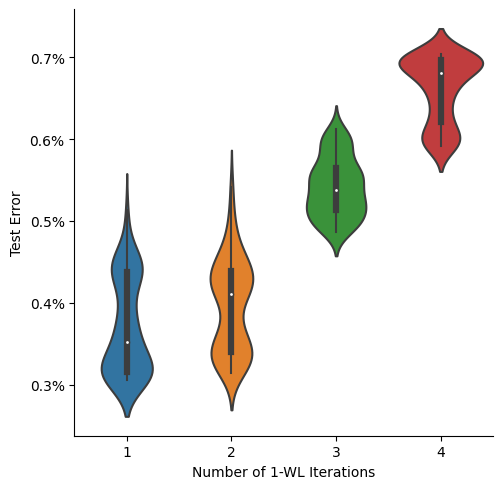

In [13]:
k_wl_df = runs_df[runs_df['model_type'] == '1-WL+NN'][['k_wl', 'dataset', 'test_error']].reset_index()
k_wl_df['k_wl'] = k_wl_df['k_wl'].astype(int)
k_wl_df.dropna(inplace=True)

for ds in k_wl_df['dataset'].unique():
    g = sns.catplot(data=k_wl_df[k_wl_df['dataset'] == ds], y='test_error', x='k_wl', kind='violin')
    g.set_titles('{col_name}')
    g.set_ylabels('Test Error')
    g.set_xlabels('Number of 1-WL Iterations')
    g.axes[0, 0].set_yticklabels([f'{round(y, 2)}%' for y in g.axes[0, 0].get_yticks()])

    #g.savefig(f'../LaTeX/figures/k_wl_violin_{ds}.pdf', bbox_inches='tight')

Total computation time: 1624.23 hours
